In [20]:
import pymc3 as pm
import numpy as np
import theano
import theano.tensor as tt
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd

from tvb_inversion.pymc3.plot import plot_posterior_samples
from tvb_inversion.base.diagnostics import (zscore, shrinkage)

In [3]:
inference_data = az.from_netcdf("pymc3_data/2023-01-02_1629.nc")
inference_summary = pd.read_json("pymc3_data/2023-01-02_1629.json")

In [4]:
X = inference_data.observed_data.x_obs.values

In [5]:
chains = len(inference_data.sample_stats.chain)
draws = len(inference_data.sample_stats.draw)

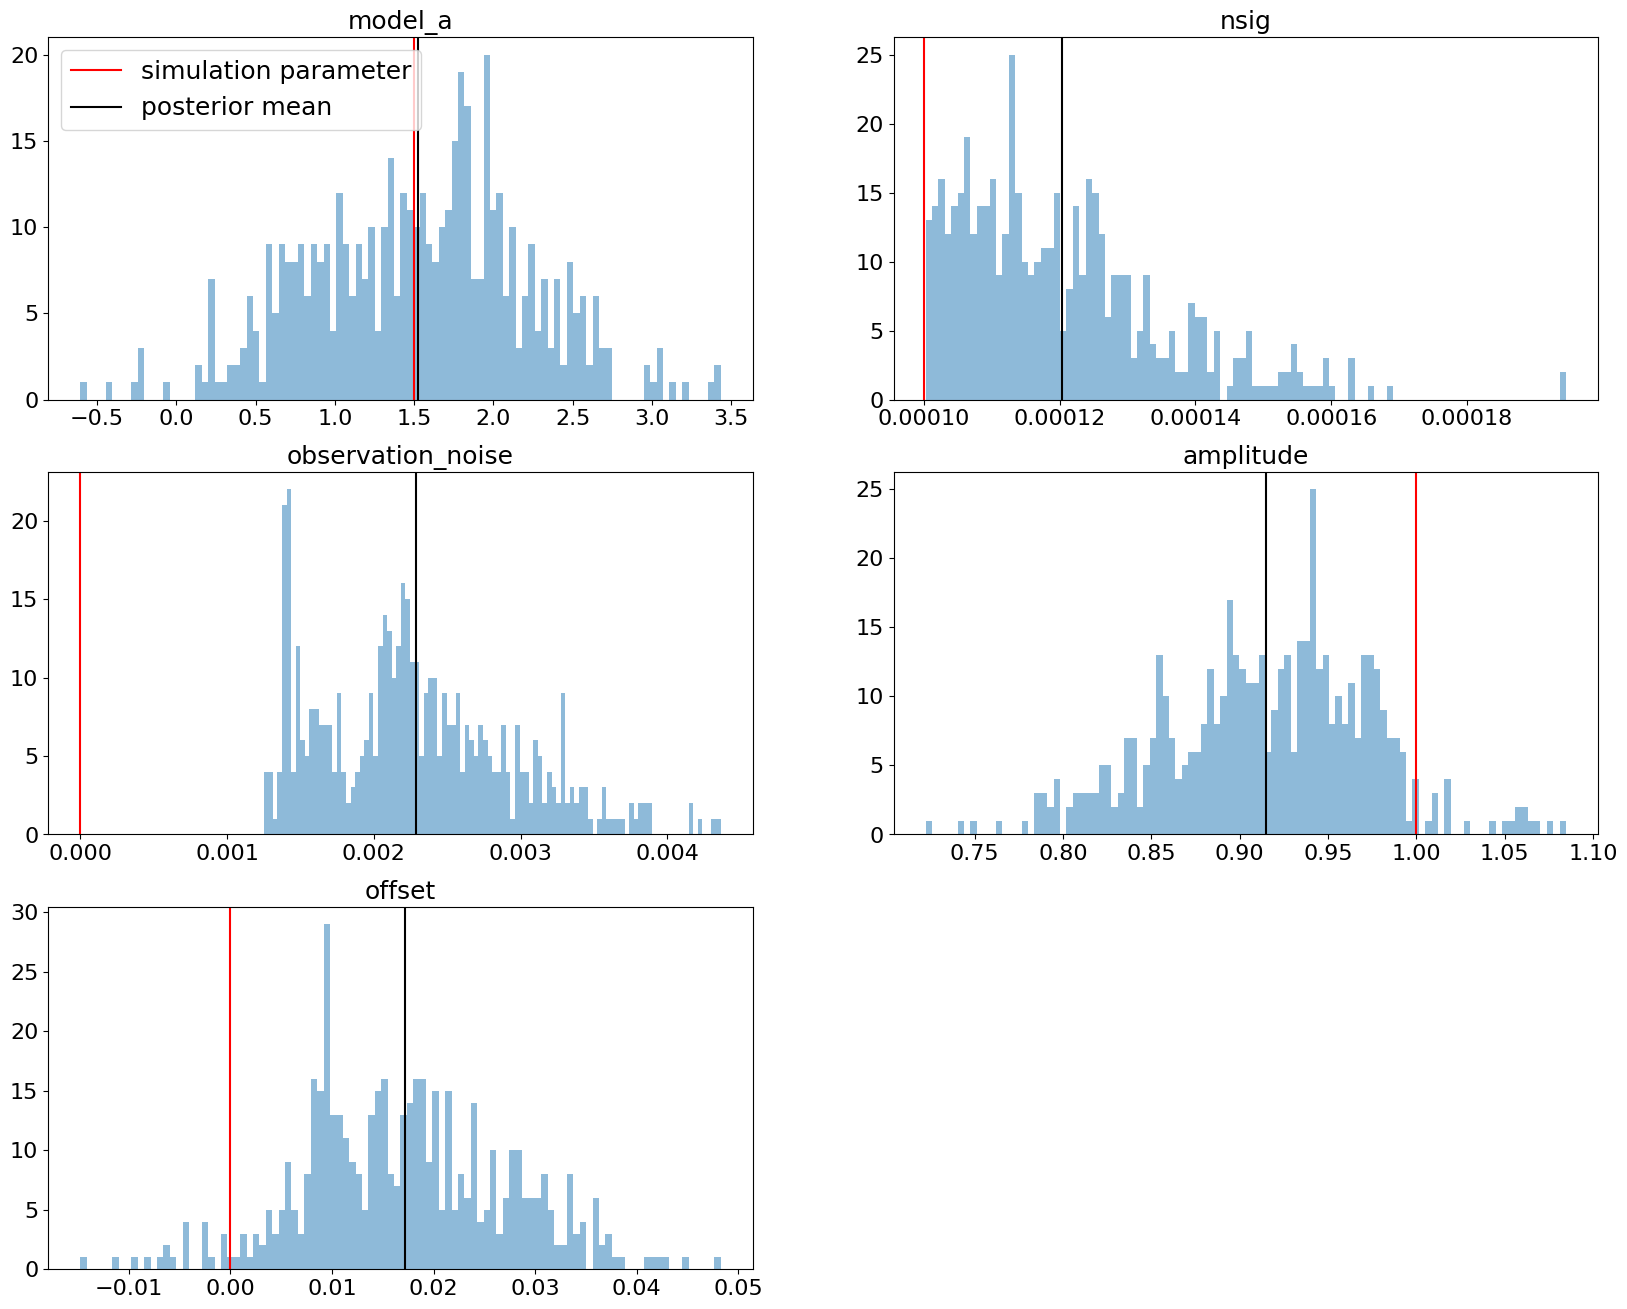

In [6]:
init_params = {
    "model_a": 1.5,
    "nsig": 1e-4,
    "observation_noise": 0.0,
    "amplitude": 1.0,
    "offset": 0.0
}

plot_posterior_samples(inference_data, init_params)

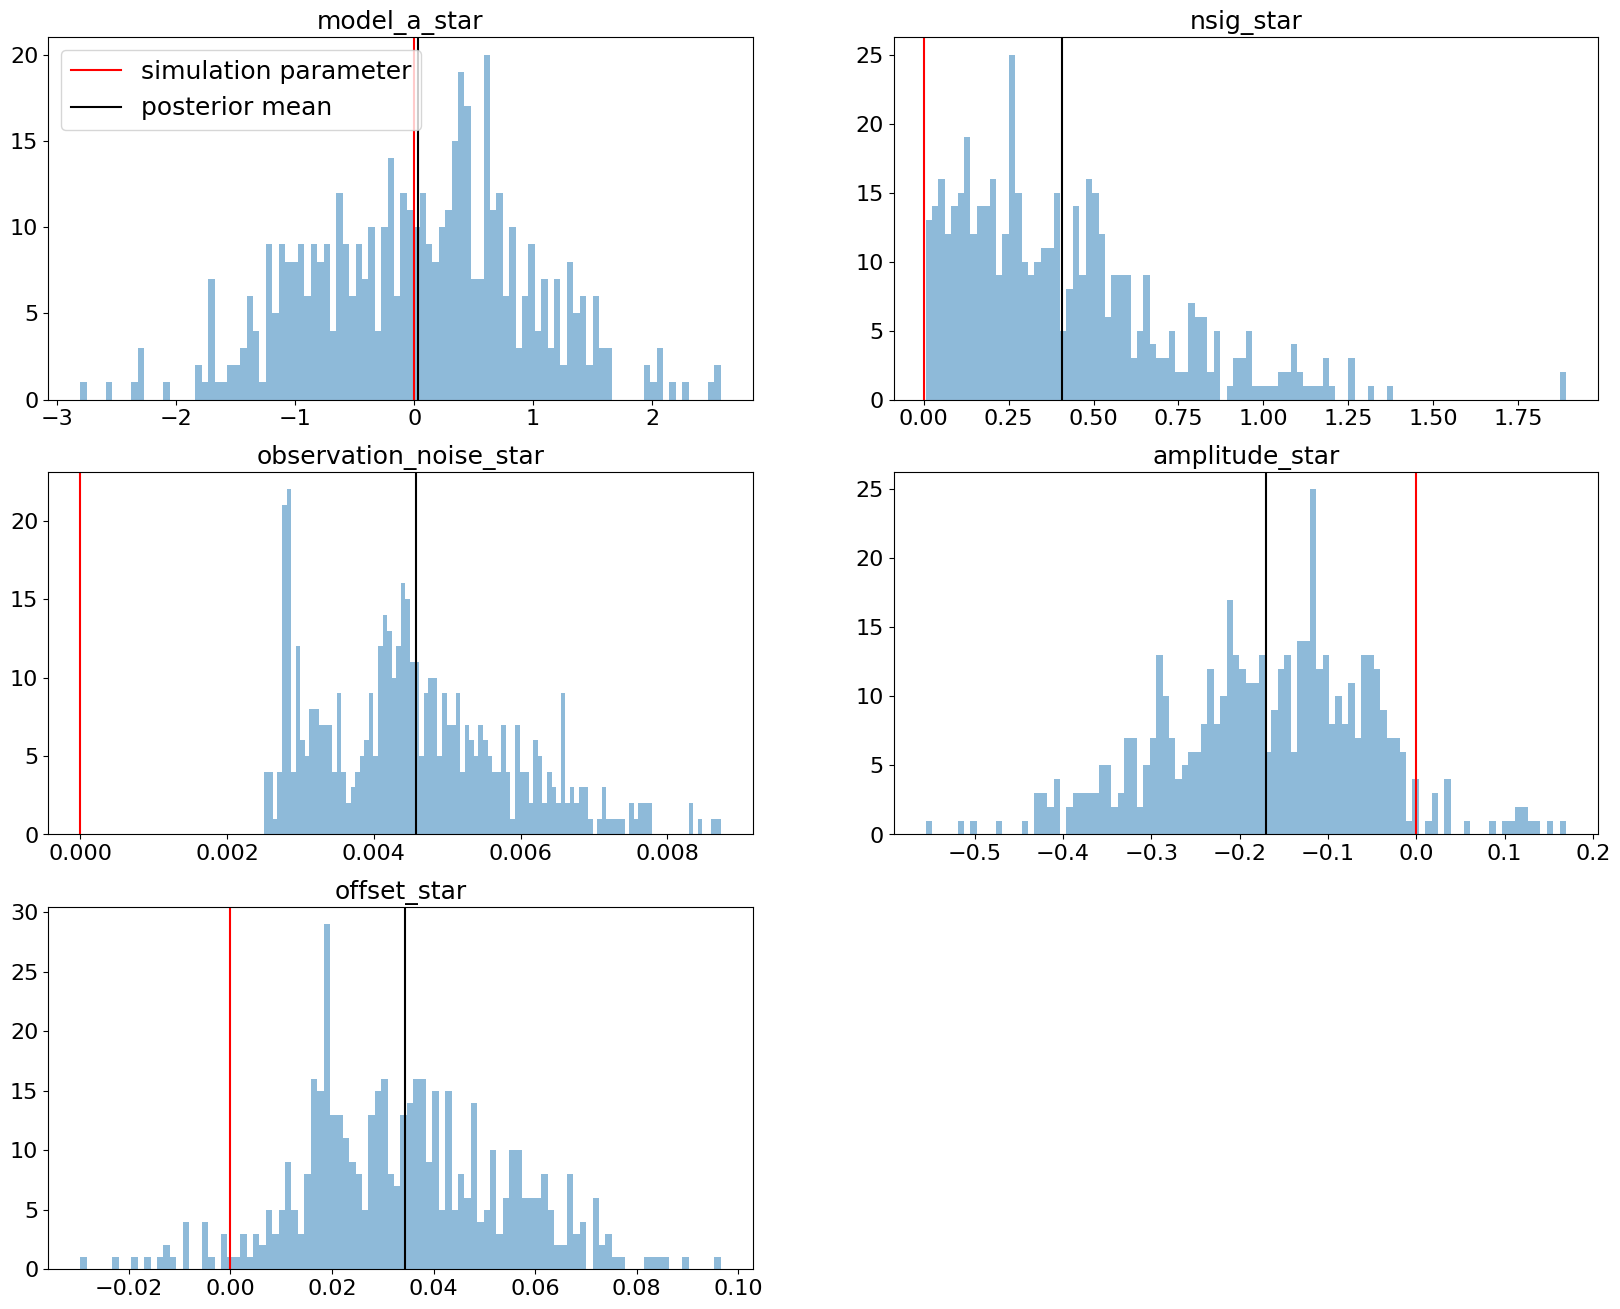

In [7]:
init_params = {
    "model_a_star": 0.0,
    "nsig_star": 0.0,
    "observation_noise_star": 0.0,
    "amplitude_star": 0.0,
    "offset_star": 0.0
}

plot_posterior_samples(inference_data, init_params)

In [8]:
posterior_x_obs = inference_data.posterior_predictive.x_obs.values.reshape(
    (chains*draws, *X.shape[:-1]))

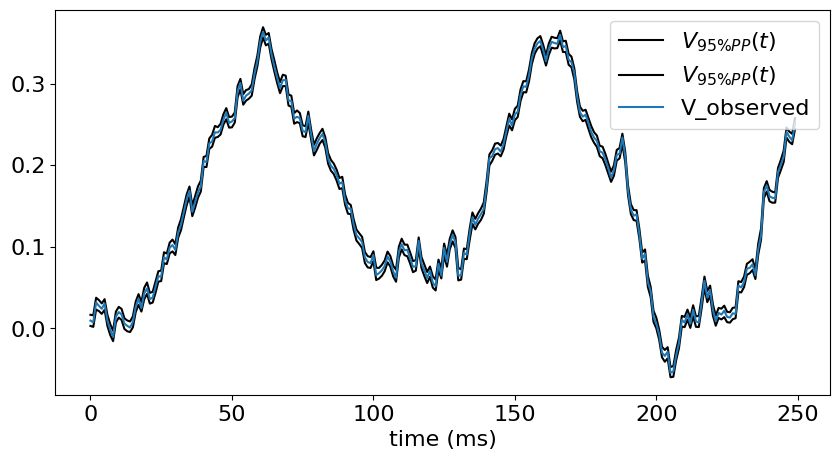

In [14]:
f3 = plt.figure(figsize=(10,5))
plt.plot(np.percentile(posterior_x_obs[:, :, 0], [2.5, 97.5], axis=0).T,
              "k", label=r"$V_{95\% PP}(t)$")
plt.plot(X[:, 0, 0], label="V_observed")
plt.legend(fontsize=16)
plt.xlabel("time (ms)", fontsize=16)
plt.tick_params(axis="both", labelsize=16)

plt.show()

In [15]:
inference_summary.loc[
    ["model_a_star[0]", "nsig_star",
     "amplitude_star", "offset_star", "observation_noise_star"]]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
model_a_star[0],0.029,0.915,-1.593,1.659,0.045,0.048,427,261,1.00
nsig_star,0.406,0.306,0.005,0.960,0.020,0.014,231,276,1.03
amplitude_star,-0.170,0.117,-0.423,-0.002,0.017,0.013,54,217,1.04
offset_star,0.034,0.020,0.001,0.075,0.004,0.003,30,264,1.05
observation_noise_star,0.005,0.001,0.003,0.007,0.001,0.001,3,24,1.74


In [17]:
inference_summary.loc[
    ["model_a[0]", "nsig",
     "amplitude", "offset", "observation_noise"]]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
model_a[0],1.522,0.686,0.306,2.744,0.034,0.024,427,261,1.00
nsig,0.000,0.000,0.000,0.000,0.000,0.000,231,276,1.03
amplitude,0.915,0.059,0.789,0.999,0.008,0.006,54,217,1.04
offset,0.017,0.010,0.000,0.037,0.002,0.001,30,264,1.05
observation_noise,0.002,0.001,0.001,0.003,0.000,0.000,3,24,1.74


In [18]:
def get_posterior_mean(idata, params):
    posterior = np.asarray([idata.posterior[param].values.reshape((idata.posterior[param].values.size,)) for param in params])
    return posterior.mean(axis=1)

def get_posterior_std(idata, params):
    posterior = np.asarray([idata.posterior[param].values.reshape((idata.posterior[param].values.size,)) for param in params])
    return posterior.std(axis=1)

In [21]:
# zscores
posterior_mean = get_posterior_mean(inference_data,
                                    ["model_a", "nsig", "amplitude", "offset", "observation_noise"])

posterior_std = get_posterior_std(inference_data,
                                  ["model_a", "nsig", "amplitude", "offset", "observation_noise"])

ground_truth = np.array(
    [1.5, 1e-4, 1.0, 0.0, 0.0])

zscores = zscore(ground_truth, posterior_mean, posterior_std)

In [22]:
# shrinkages
posterior_std = get_posterior_std(inference_data,
                                  ["model_a_star", "nsig_star",
                                   "amplitude_star", "offset_star", "observation_noise_star"])

prior_std = np.ones((5,))

shrinkages = shrinkage(prior_std, posterior_std)

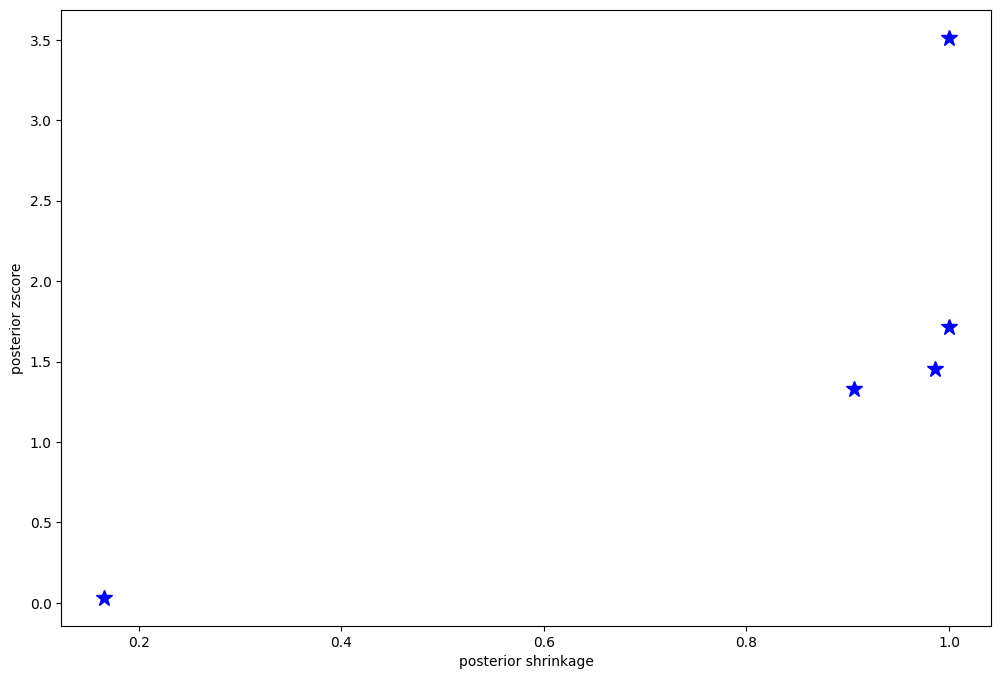

In [23]:
f4 = plt.figure(figsize=(12,8))
plt.plot(shrinkages, zscores, color="blue", linewidth=0, marker="*", markersize=12)
plt.xlabel("posterior shrinkage")
plt.ylabel("posterior zscore")
plt.plot();